In [73]:
import numpy as np 
import control as ct
from parameters import Orbit_Parameters
from orbit import Orbit_Environment
import matplotlib.pyplot as plt

In [74]:
J = Orbit_Parameters.INERTIAL_MATRIX
J_inv = np.linalg.inv(J)

A = np.block([[np.zeros((3, 3)), 0.5 * np.eye(3)],[np.zeros((3, 3)), np.zeros((3, 3))]])
B = np.block([[np.zeros((3, 3))],[J_inv]])
C = np.eye(6)
D = np.zeros((6, 3))

In [75]:
sys = ct.ss(A, B, C, D)
poles = ct.poles(sys)

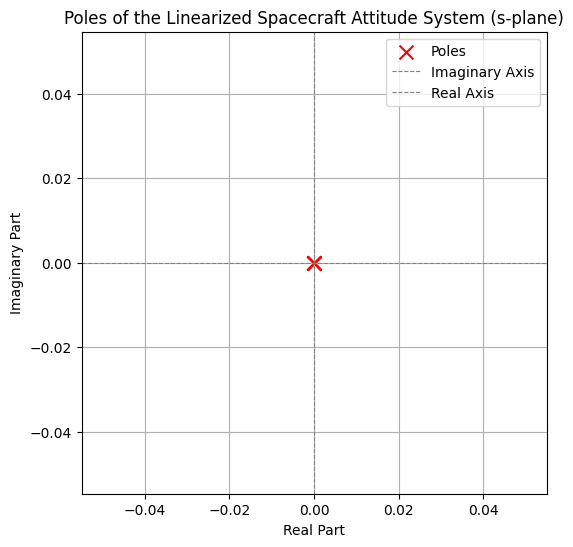

In [76]:
plt.figure(figsize=(6, 6))
plt.scatter(np.real(poles), np.imag(poles), marker='x', color='red', s=100, label='Poles')

# Draw the imaginary axis (y-axis)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Imaginary Axis')
# Draw the real axis (x-axis)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='Real Axis')

plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Poles of the Linearized Spacecraft Attitude System (s-plane)')
plt.grid(True)
plt.legend()
plt.axis('equal') # Ensure the scales are equal for proper visualization
plt.show()

In [77]:
Q = np.diag([100, 100, 100,  5, 5, 5])
R = np.diag([0.01, 0.01, 0.01])
K, S, E = ct.lqr(A, B, Q, R)

In [78]:
A_cl = A - B @ K
sys_cl = ct.ss(A_cl, B, C, D)
closed_loop_poles = ct.poles(sys_cl)

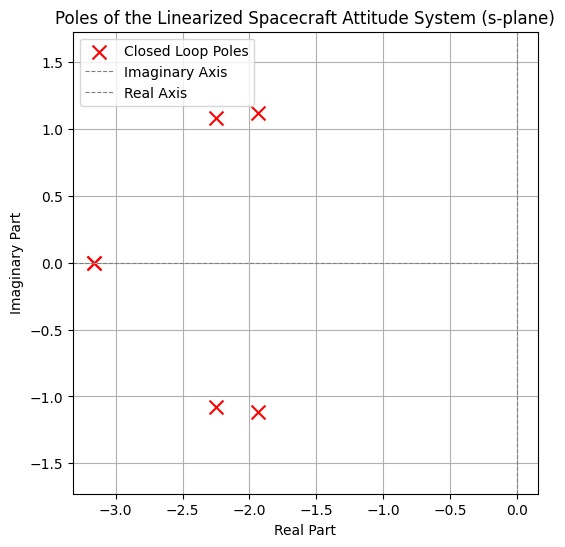

In [79]:
plt.figure(figsize=(6, 6))
plt.scatter(np.real(closed_loop_poles), np.imag(closed_loop_poles), marker='x', color='red', s=100, label='Closed Loop Poles')

# Draw the imaginary axis (y-axis)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Imaginary Axis')
# Draw the real axis (x-axis)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='Real Axis')

plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Poles of the Linearized Spacecraft Attitude System (s-plane)')
plt.grid(True)
plt.legend()
plt.axis('equal') # Ensure the scales are equal for proper visualization
plt.show()

In [80]:
initial_state = np.array([0.1, -0.2, 0.15, 0.01, -0.02, 0.03])

T_ir, yout_ir = ct.initial_response(sys_cl, X0=initial_state)

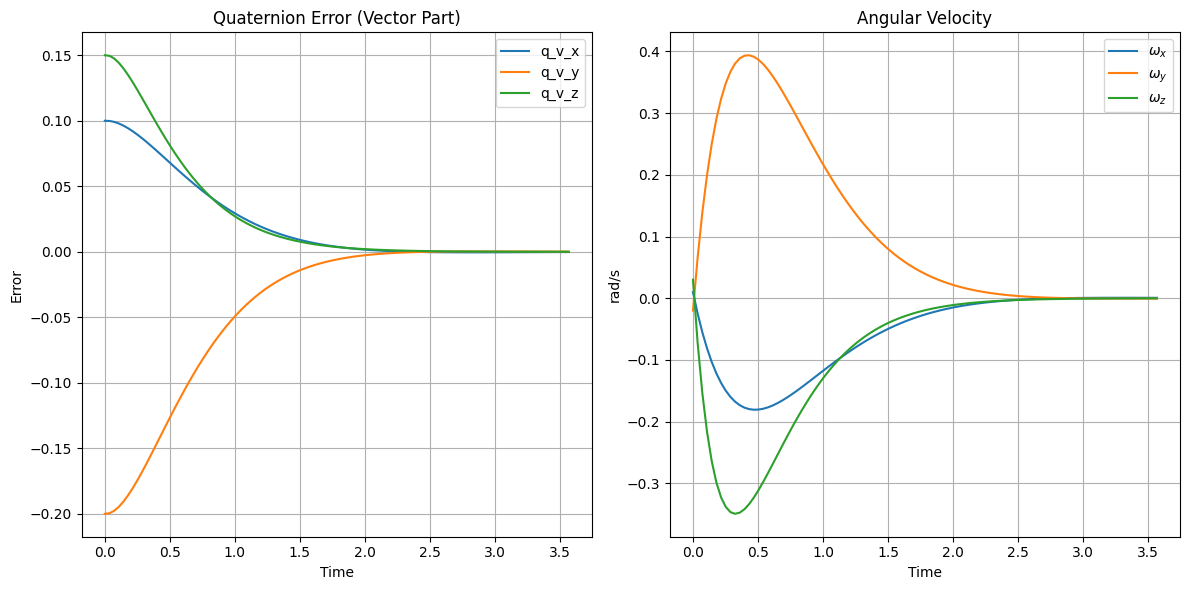

In [81]:
# Plot the closed-loop response to the initial condition
plt.figure(figsize=(12, 6))

# Plot Quaternion Error
plt.subplot(1, 2, 1)
plt.plot(T_ir, yout_ir[0], label='q_v_x')
plt.plot(T_ir, yout_ir[1], label='q_v_y')
plt.plot(T_ir, yout_ir[2], label='q_v_z')
plt.title('Quaternion Error (Vector Part)')
plt.xlabel('Time')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

# Plot Angular Velocity
plt.subplot(1, 2, 2)
plt.plot(T_ir, yout_ir[3], label=r'$\omega_x$')
plt.plot(T_ir, yout_ir[4], label=r'$\omega_y$')
plt.plot(T_ir, yout_ir[5], label=r'$\omega_z$')
plt.title('Angular Velocity')
plt.xlabel('Time')
plt.ylabel('rad/s')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
nadir_pointing_trajectory = np.array([
    [0.1, -0.05, 0.02, 0.01, -0.005, 0.002],
    [0.05, -0.02, 0.01, 0.005, -0.002, 0.001],
    [0.01, -0.005, 0.002, 0.001, -0.001, 0.0005],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
])

In [83]:
time_points = np.linspace(0, 30, len(nadir_pointing_trajectory))
t_final = time_points[-1]
dt = 0.1
time = np.arange(0, t_final + dt, dt)

In [84]:
initial_state = nadir_pointing_trajectory[0]
current_state = initial_state
state_history = [initial_state]
control_history = []
state_error_history = []
trajectory_index = 0

In [85]:
def state_derivative_using_AB(current_state, control_torque, A, B):
    x = current_state
    u = control_torque 
    x_dot = A @ x + B @ u
    return x_dot

In [86]:
# Simulation loop with RK4 and disturbance using A and B
for t in time:
    if trajectory_index < len(nadir_pointing_trajectory):
        target_state = nadir_pointing_trajectory[trajectory_index]
        state_error = current_state - target_state
        control_torque = -K @ state_error

        k1 = dt * state_derivative_using_AB(current_state, control_torque,  A, B)
        k2 = dt * state_derivative_using_AB(current_state + 0.5 * k1, control_torque,  A, B)
        k3 = dt * state_derivative_using_AB(current_state + 0.5 * k2, control_torque,  A, B)
        k4 = dt * state_derivative_using_AB(current_state + k3, control_torque,  A, B)

        current_state = current_state + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        state_history.append(current_state.copy())
        control_history.append(control_torque)
        state_error_history.append(state_error)

        if t >= time_points[trajectory_index] and trajectory_index < len(time_points) - 1:
            trajectory_index += 1
    else:
        break

state_history = np.array(state_history).T
control_history = np.array(control_history).T
state_error_history = np.array(state_error_history).T
time_history = np.linspace(0, dt * (len(state_history[0]) - 1), len(state_history[0]))

In [87]:
time_desired = np.linspace(0,30, 100)
error_time_history = np.linspace(0,30, len(state_error_history.T))

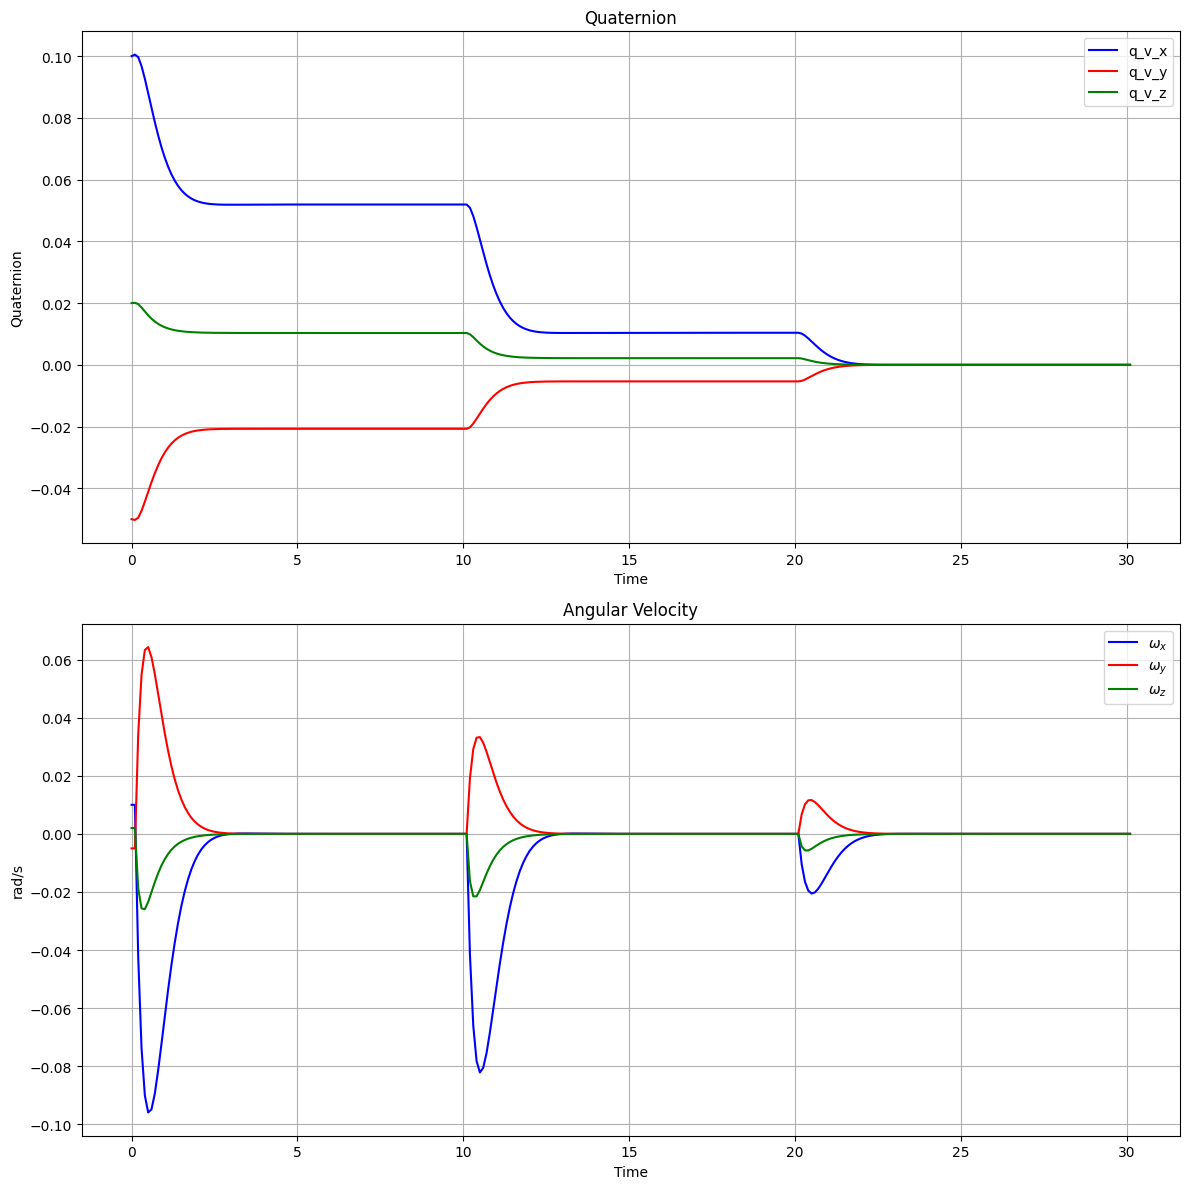

In [88]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(time_history, state_history[0], 'b-',label='q_v_x')
plt.plot(time_history, state_history[1], 'r-', label='q_v_y')
plt.plot(time_history, state_history[2], 'g-', label='q_v_z')


plt.title('Quaternion')
plt.xlabel('Time')
plt.ylabel('Quaternion')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_history, state_history[3], 'b-', label=r'$\omega_x$')
plt.plot(time_history, state_history[4], 'r-', label=r'$\omega_y$')
plt.plot(time_history, state_history[5], 'g-', label=r'$\omega_z$')

plt.title('Angular Velocity')
plt.xlabel('Time')
plt.ylabel('rad/s')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [89]:
orbit_env = Orbit_Environment(
        a=Orbit_Parameters.SEMI_MAJOR_AXIS,
        ecc=Orbit_Parameters.ECCENTRICITY,
        inc=Orbit_Parameters.INCLINATION,
        raan=Orbit_Parameters.RAAN,
        argp=Orbit_Parameters.ARGP,
        nu=Orbit_Parameters.TRUE_ANOMALY,
        Cd=Orbit_Parameters.DRAG,
        A=Orbit_Parameters.REFERENCE_AREA,
        rho=Orbit_Parameters.ATMOSPHERIC_DENSITY,
        noise_mean=Orbit_Parameters.NOISE_MEAN,
        noise_std=Orbit_Parameters.NOISE_STD
    )

In [90]:
desired_quaternions = orbit_env.Desired_Body_Quaternions_LVLH()
desired_omega = orbit_env.Desired_Body_Angular_Velocities_LVLH()

In [91]:
desired_quaternions = desired_quaternions[1:80]
desired_omega = desired_omega[1:80]

In [92]:
desired_trajectory = []

for i in range(len(desired_quaternions)):
    desired_trajectory.append(np.concatenate([desired_quaternions[i].imaginary, desired_omega[i]]))
    
desired_trajectory = np.array(desired_trajectory)

In [93]:
time_points = np.linspace(0, 30, len(desired_trajectory))
t_final = time_points[-1]
dt = 0.1
time = np.arange(0, t_final + dt, dt)

In [94]:
initial_state = desired_trajectory[0]
current_state = initial_state
state_history = [initial_state]
control_history = []
state_error_history = []
trajectory_index = 0

In [95]:
def state_derivative_using_AB(current_state, control_torque, A, B):
    x = current_state
    u = control_torque 
    x_dot = A @ x + B @ u
    return x_dot

In [96]:
# Simulation loop with RK4 and disturbance using A and B
for t in time:
    if trajectory_index < len(desired_trajectory):
        target_state = desired_trajectory[trajectory_index]
        state_error = current_state - target_state
        control_torque = -K @ state_error

        k1 = dt * state_derivative_using_AB(current_state, control_torque,  A, B)
        k2 = dt * state_derivative_using_AB(current_state + 0.5 * k1, control_torque,  A, B)
        k3 = dt * state_derivative_using_AB(current_state + 0.5 * k2, control_torque,  A, B)
        k4 = dt * state_derivative_using_AB(current_state + k3, control_torque,  A, B)

        current_state = current_state + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        state_history.append(current_state.copy())
        control_history.append(control_torque)
        state_error_history.append(state_error)

        if t >= time_points[trajectory_index] and trajectory_index < len(time_points) - 1:
            trajectory_index += 1
    else:
        break

state_history = np.array(state_history).T
control_history = np.array(control_history).T
state_error_history = np.array(state_error_history).T
time_history = np.linspace(0, dt * (len(state_history[0]) - 1), len(state_history[0]))

In [97]:
time_desired = np.linspace(0,30, len(desired_trajectory))
error_time_history = np.linspace(0,30, len(state_error_history.T))

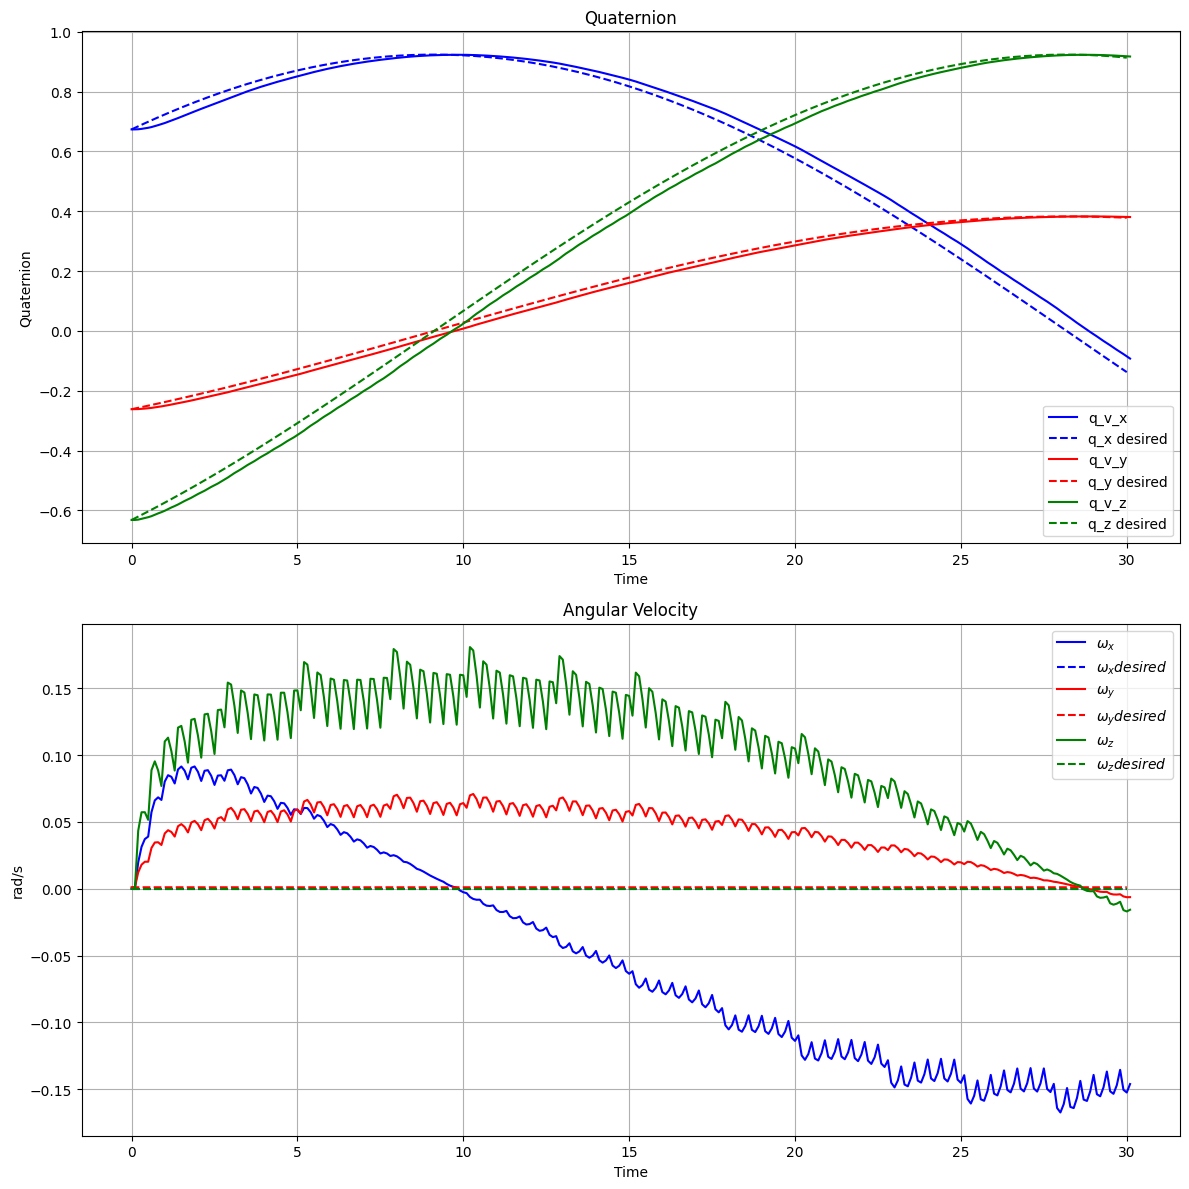

In [99]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(time_history, state_history[0], 'b-',label='q_v_x')
plt.plot(time_desired, desired_trajectory.T[0], 'b--', label='q_x desired')
plt.plot(time_history, state_history[1], 'r-', label='q_v_y')
plt.plot(time_desired, desired_trajectory.T[1], 'r--', label='q_y desired')
plt.plot(time_history, state_history[2], 'g-', label='q_v_z')
plt.plot(time_desired, desired_trajectory.T[2], 'g--', label='q_z desired')

plt.title('Quaternion')
plt.xlabel('Time')
plt.ylabel('Quaternion')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_history, state_history[3], 'b-', label=r'$\omega_x$')
plt.plot(time_desired, desired_trajectory.T[3] , 'b--', label=r'$\omega_x desired$')

plt.plot(time_history, state_history[4], 'r-', label=r'$\omega_y$')
plt.plot(time_desired, desired_trajectory.T[4] , 'r--', label=r'$\omega_y desired$')
plt.plot(time_history, state_history[5], 'g-', label=r'$\omega_z$')
plt.plot(time_desired, desired_trajectory.T[5] , 'g--', label=r'$\omega_z desired$')

plt.title('Angular Velocity')
plt.xlabel('Time')
plt.ylabel('rad/s')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()